# Emotion Detection in Sinhala Language Texts in Social Media
## By 2021/E/045 and 2021/E053

In [ ]:
!pip install --upgrade -r requirements.txt

In [1]:
import torch
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA toolkit version:", torch.version.cuda)
print("Device name:", torch.cuda.get_device_name(0))

Torch version: 2.7.1+cu118
CUDA available: True
CUDA toolkit version: 11.8
Device name: NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
from transformers import pipeline

pipe = pipeline("fill-mask", model="NLPC-UOM/SinBERT-large")
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("NLPC-UOM/SinBERT-large")
model = AutoModelForMaskedLM.from_pretrained("NLPC-UOM/SinBERT-large")

F:\UOJE\Research\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cuda:0


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import cohen_kappa_score


In [5]:
dataset_path='./raw/Dataset.csv'
df = pd.read_csv(dataset_path, encoding='utf-8')
df = df.rename(columns={'Annotator 1': 'emotion_1', 'Annotator 2(Yasitha)': 'emotion_2', 'Phrase': 'text'})
df = df.loc[:, ~df.columns.str.contains(r'^Unnamed')]

In [6]:
df.head()

,emotion_1,emotion_2,text
0,joy,joy,නියම සිංහල මහත්මයෙක්.
1,joy,joy,අන්න මිනිස්සු...
2,disgust,anger,හොරා හොද මිනිහෙක් නම් අනේ මහත්තයෝ සමාවෙන්න කිය...
3,NaN,NaN,තව ඩිංගෙන් ලබු ගෙඩියත් කොස් ගෙඩි සහ පොල් ගෙඩි ...
4,disgust,disgust,"බතල වැලට, කොස්ගෙඩි අටට, උසාවි ගිහින් රිමන්ඩ් ක..."


## Data Preprocessing

### Changing the data type of the columns

In [7]:
# Use the renamed columns
df['emotion_2'] = df['emotion_2'].astype(str).str.strip()
df['emotion_1'] = df['emotion_1'].astype(str).str.strip()
df['emotion_2'] = df['emotion_2'].astype('category')
df['emotion_1'] = df['emotion_1'].astype('category')


# Verify the datatypes
print(df.dtypes)

emotion_1    category
emotion_2    category
text           object
dtype: object


In [8]:
df.head()

,emotion_1,emotion_2,text
0,joy,joy,නියම සිංහල මහත්මයෙක්.
1,joy,joy,අන්න මිනිස්සු...
2,disgust,anger,හොරා හොද මිනිහෙක් නම් අනේ මහත්තයෝ සමාවෙන්න කිය...
3,nan,nan,තව ඩිංගෙන් ලබු ගෙඩියත් කොස් ගෙඩි සහ පොල් ගෙඩි ...
4,disgust,disgust,"බතල වැලට, කොස්ගෙඩි අටට, උසාවි ගිහින් රිමන්ඩ් ක..."


### Cohen's Kappa Score

In [9]:
cohen_kappa_score(df['emotion_1'], df['emotion_2'])

0.793339071586885

In [10]:
string_cols = ['emotion_1', 'emotion_2']  # Add any other relevant string columns

for col in string_cols:
    df[col] = df[col].astype(str).str.replace(r'\s+', ' ', regex=True)  # normalize multiple spaces to one
    df[col] = df[col].str.strip()

In [11]:
df[''] = (
    df['emotion_1']
    .astype(str)
    .str.strip()              # remove leading/trailing spaces
    .str.replace(r'\s+', ' ', regex=True)  # collapse internal whitespace
    .str.lower()              # unify casing (optional)
)
df[''] = (
    df['emotion_2']
    .astype(str)
    .str.strip()              # remove leading/trailing spaces
    .str.replace(r'\s+', ' ', regex=True)  # collapse internal whitespace
    .str.lower()              # unify casing (optional)
)
# 3. Consolidate duplicate “disgust” entries
#    Any “disgust” (with or without stray spaces) now maps to canonical 'disgust'

In [12]:
counts1 = df['emotion_1'].value_counts()
small_labels = counts1[counts1 < 10].index.tolist()  # threshold = 10
df = df[~df['emotion_1'].isin(small_labels)]

counts2 = df['emotion_2'].value_counts()
small_labels2 = counts2[counts2 < 10].index.tolist()  # threshold = 10
df = df[~df['emotion_2'].isin(small_labels2)]

ano_1_count = df['emotion_1'].value_counts()
ano_2_count =df['emotion_2'].value_counts()
print(f" Annontator 1 -> {ano_1_count} \n\n Annontator 2 -> {ano_2_count}")

 Annontator 1 -> emotion_1
nan         7541
joy          804
disgust      642
sadness      554
surprise     537
anger        520
fear         509
Name: count, dtype: int64 

 Annontator 2 -> emotion_2
nan         6957
joy          941
disgust      747
sadness      694
anger        629
surprise     595
fear         544
Name: count, dtype: int64


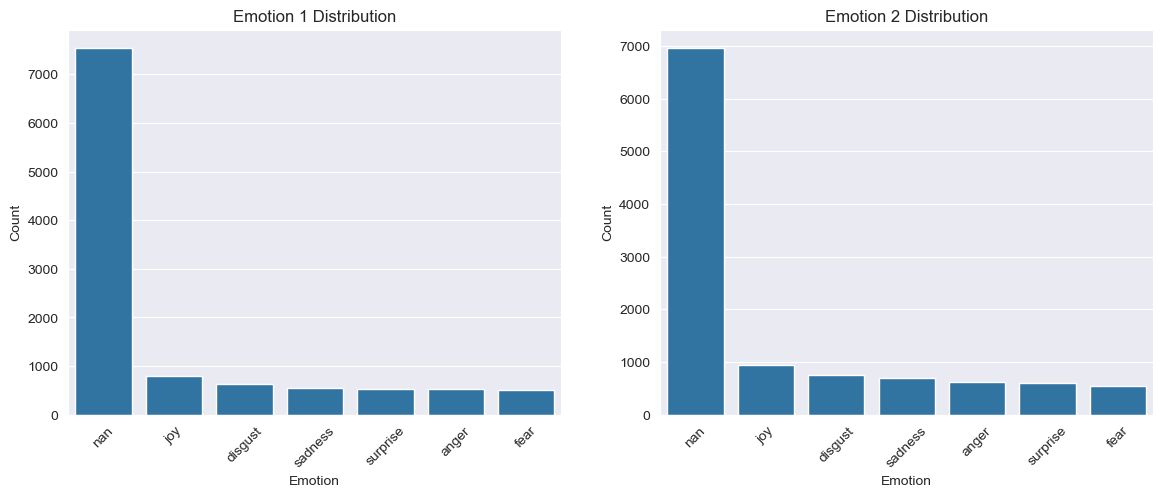

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.countplot(ax=axes[0], x='emotion_1', data=df, order=df['emotion_1'].value_counts().index)
axes[0].set_title('Emotion 1 Distribution')
axes[0].set_xlabel('Emotion')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

sns.countplot(ax=axes[1], x='emotion_2', data=df, order=df['emotion_2'].value_counts().index)
axes[1].set_title('Emotion 2 Distribution')
axes[1].set_xlabel('Emotion')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)


plt.show()

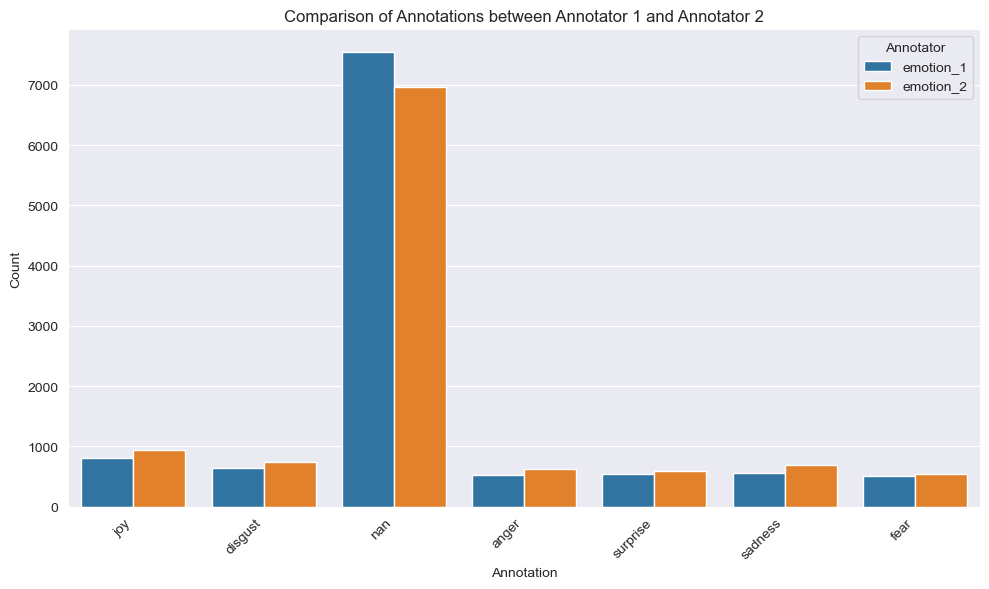

In [14]:
dataset_melted = df[['emotion_1', 'emotion_2']].melt(var_name='Annotator', value_name='Annotation')

# Create a bar plot using seaborn
plt.figure(figsize=(10, 6))
sns.countplot(data=dataset_melted, x='Annotation', hue='Annotator')
plt.title('Comparison of Annotations between Annotator 1 and Annotator 2')
plt.xlabel('Annotation')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

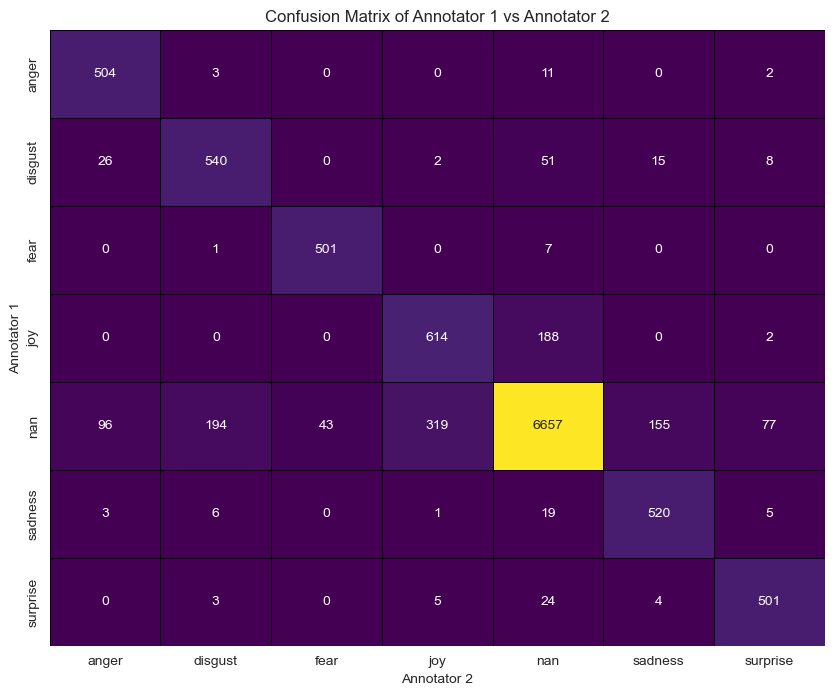

In [15]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(df['emotion_1'],df['emotion_2'])

labels = np.unique(df[['emotion_1', 'emotion_2']].values)
# Create a DataFrame from the confusion matrix for better visualization with seaborn
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='viridis',vmax=cm_df.values.max(), cbar=False, linewidths=0.5, linecolor='black')
plt.title('Confusion Matrix of Annotator 1 vs Annotator 2')
plt.xlabel('Annotator 2')
plt.ylabel('Annotator 1')
plt.show()